# Introducción
Para el desarrollo de esta tarea se escogió de la base de datos entregada el planeta HD 191939 b, después de haber probado varios planetas y secotres posibles. En general las celdas de texto y comentarios están en español para un desarrollo más natural por mi parte sin embargo los nombres de variables en el código y gráficos están en inglés por convención para mantener la universalidad de estos.

In [223]:
# carga de librerias a utilizar

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

# P1

## 1

In [224]:
# elección del planeta y carga de datos
target = 'HD 191939 b'
search_result = lk.search_targetpixelfile(target, mission='TESS')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 19,2019,SPOC,120,269701147,0.0
1,TESS Sector 18,2019,SPOC,120,269701147,0.0
2,TESS Sector 17,2019,SPOC,120,269701147,0.0
3,TESS Sector 16,2019,SPOC,120,269701147,0.0
4,TESS Sector 15,2019,SPOC,120,269701147,0.0
5,TESS Sector 21,2020,SPOC,120,269701147,0.0
6,TESS Sector 25,2020,SPOC,120,269701147,0.0
7,TESS Sector 22,2020,SPOC,120,269701147,0.0
8,TESS Sector 24,2020,SPOC,120,269701147,0.0


Se visualiza una ventana de tamaño 15x15 para poder apreciar bien el planeta sin contaminar la imagen con otros posibles cuerpos celestes como ocurriría en caso de visualizar una ventana mayor. No se escoge un sector en particular porque como se puede notar en la búsqueda todos son de mediciones recientes (a lo más 4 años) además que el archivo descargado por defecto tal como se aprecia más adelante en la animación tiene ciclos de subida generalizada de flujo más interesantes que otros sectores en particular probados (por ejemplo el 55), en que este efecto es menos notorio. Esta irregularidad en el flujo nos podría llevar a un análisis más completo e interesante a posterior.

c:\Users\rirc1\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 21 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


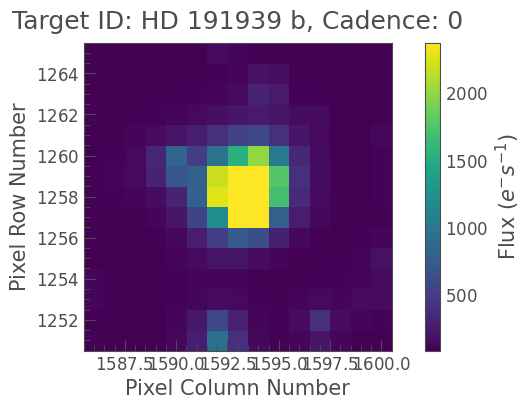

In [225]:
# descarga de imagen y ploteo inicial
tpf = lk.search_tesscut(target=target).download(cutout_size=(15,15))
tpf.plot();

In [226]:
# animación de la imagen
tpf.animate()

En la animación podemos observar dos momentos en que el el flujo aumenta vertiginosamente (cuando el color se aclara en todos los píxeles), esto claramente se debe a la luz dispersada ('scattering light') por otros cuerpos celestes al momento de realizar las mediciones. Este fenómeno físico distorsiona completamente las mediciones generando picos irregularmente altos y puede ser fuente de inexactitudes en estudios a realizar a futuro.

In [ ]:
# caracterización del flujo
tpf.flux.shape

(1118, 15, 15)

Para la creación de la máscara se escoge un umbral de $18 \sigma$ pues habiendo visualizado varias aperturas posibles este es el valor mínimo para el cual se obtiene una forma similar al planeta que contenga a este. Con un valor menor se estarían considerando píxeles de flujo bastante menor que darían lugar a una forma que notablemente ya no correspondería a nuestro planeta. Dado este umbral, visualizamos la apertura, fondo, región externa y además graficamos el flujo a través del tiempo.

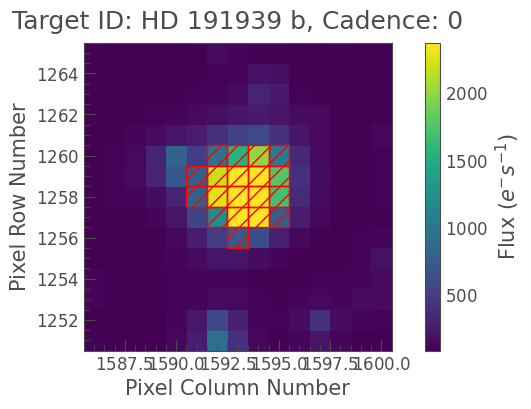

In [ ]:
# visualización de la apertura
aper = tpf.create_threshold_mask(18)
tpf.plot(aperture_mask=aper);

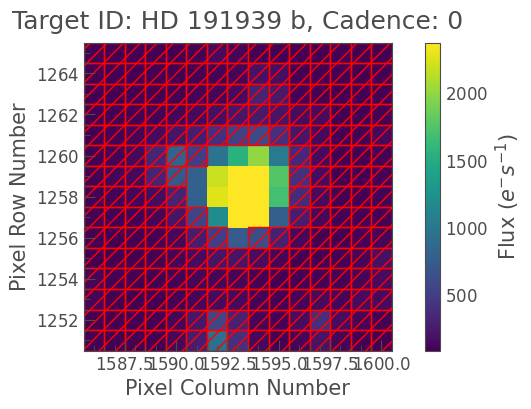

In [ ]:
# visualización del fondo
back = (tpf.create_threshold_mask(threshold=-100).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=back);

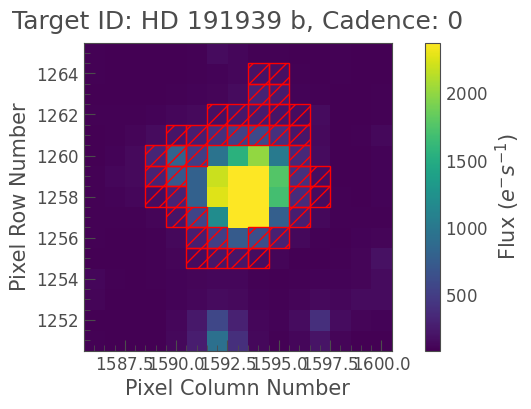

In [ ]:
# visualización de la región externa
outer_region = (tpf.create_threshold_mask(threshold=1).astype(int) - aper.astype(int)).astype(bool)
tpf.plot(aperture_mask=outer_region);

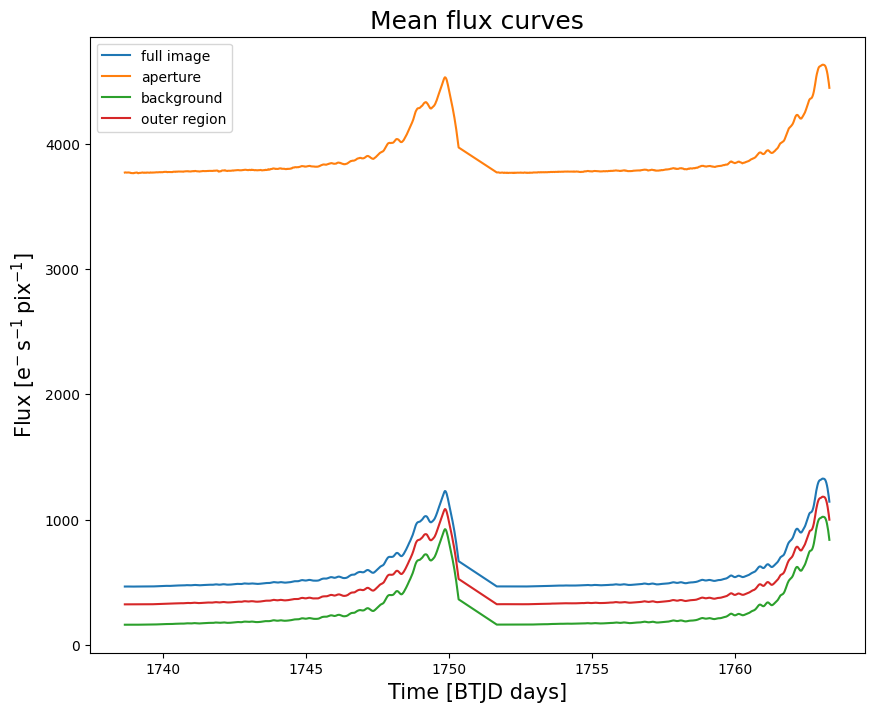

In [ ]:
# graficación de flujos medios

plt.figure(figsize=(10,8))
plt.title('Mean flux curves', fontsize=18)

plt.plot(tpf.time.value, np.mean(tpf.flux, axis=(1,2)), label='full image')

plt.plot(tpf.time.value, np.mean(tpf.flux[:, aper], axis=1), label='aperture')

plt.plot(tpf.time.value, np.mean(tpf.flux[:, back], axis=1), label='background')

plt.plot(tpf.time.value, np.mean(tpf.flux[:, outer_region], axis=1), label='outer region')

plt.ylabel('Flux [$\\mathrm{e^{-}\\,s^{-1}\\,pix^{-1}}$]', fontsize=15)
plt.xlabel('Time [BTJD days]', fontsize=15)
plt.legend()
plt.show();

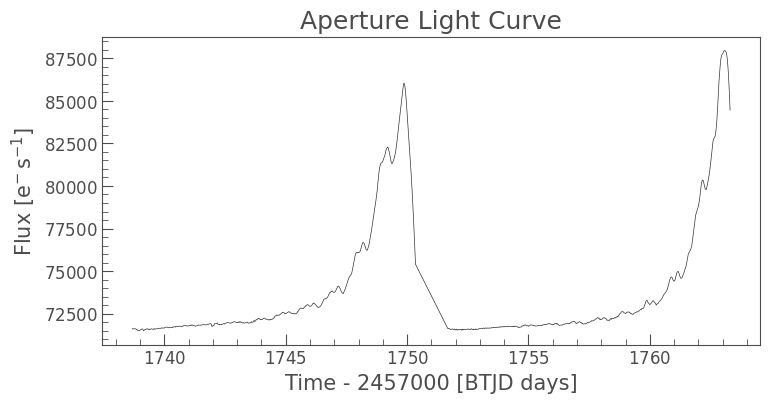

In [ ]:
# curva de flujo de apertura de luz

uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot()
plt.title('Aperture Light Curve', fontsize=18)
plt.show();

Podemos apreciar en los gráficos de curvas de flujos medios y apertura de luz que estos aumentan notablemente hacia la mitad y el final del tiempo medido, como dedujimos antes que era producto de la dispersión de luz, ahora apreciamos notoriamente la diferencia que significa este aumento de flujo (alrededor del $20\%$ según el gráfico), por lo que podremos establecer que nuestra dispersión de luz es "mala". Además, en el gráfico de flujos medios llama la atención lo similar del flujo de apertura con los flujos de la región exterior y en particular con el fondo.

Después de haber probado distintas máscaras de apertura, es apreciable la forma en que esta afecta la medición del flujo: una apertura mayor hace que se tome en cuenta el flujo proveniente de otros cuerpos celestes mientras que una apertura menor puede hacer que no consideremos todo el flujo del planeta sino una parte de este, y esto es notorio a la hora de graficar. Por lo tanto escoger una apertura adecuada es fundamental para trabajar con una buena medición del flujo del planeta.

## 2

Para corregir este efecto negativo de dispersión, primero probaremos con sustraer el flujo del fondo ('background') considerando como este a todo el espacio que no consideramos en el espacio de apertura. Primero visualicemos este flujo de fondo. En particular visualizaremos también la tendencia como la mediana para tener una cantidad más comprensible con la que trabajar.

In [ ]:
back = tpf.flux[:, ~aper]
ntimes,npix=back.shape
print('There are these many pixels %d in back, and %d times '%(npix, ntimes))

There are these many pixels 206 in back, and 1118 times 


[]

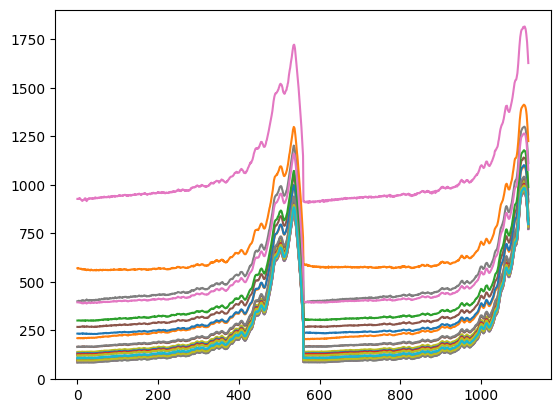

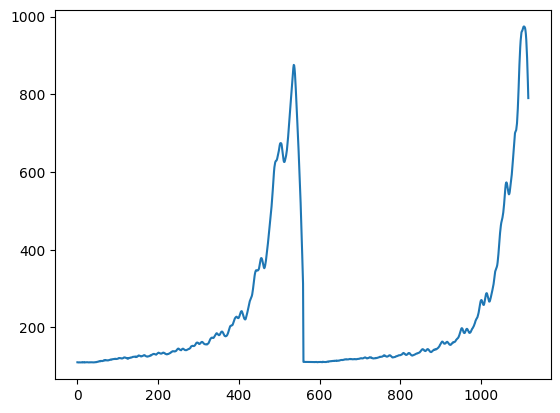

In [ ]:
# graficamos las primeras 30 curvas de luz
fig=plt.figure()
plt.plot(back[:, :30]);

# computamos la mediana
trend = np.median(back, axis=1)
fig = plt.figure()
plt.plot(trend.value)
plt.plot()

Podemos notar que nuestro flujo de fondo a simple vista es prácticamente idéntico a nuestra curva de apertura incluidos los dos picos cerca de la mitad y en el final de la medición, lo que nos da a entender que podría efectivamente ser este flujo del fondo el que perturba las mediciones del flujo de apertura, a través del efecto de dispersión mencionado. Procedemos simplemente restando el flujo de fondo a nuestra curva de flujo de apertura original sin corregir.

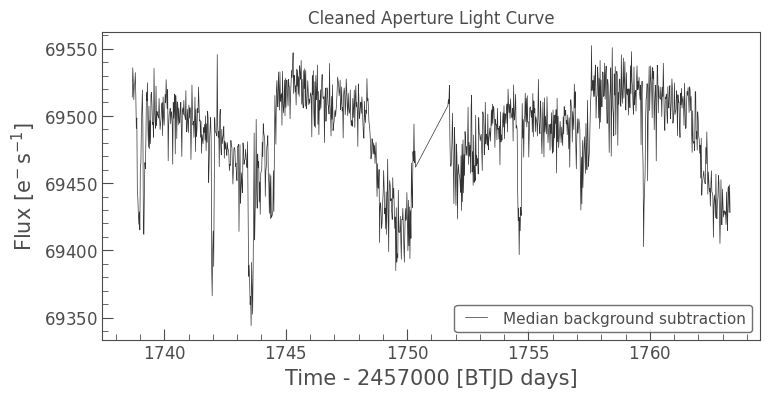

In [ ]:
median_subtracted_lc = uncorrected_lc - aper.sum()*trend
median_subtracted_lc.plot(label='Median background subtraction')
plt.title('Cleaned Aperture Light Curve')
plt.show();

Ahora sí podemos apreciar de mejor manera los tránsitos como aquellos instantes en que el flujo baja vertiginosamente a mínimos locales con cierta periodicidad. Para concluir cabe señalar las posibles fuentes de errores en el análisis expuesto; la primera de todas en orden de desarrollo es la elección de la apertura, pues en caso de esta haber sido muy grande estaría considerando flujo extra y en casos de ser muy pequeña no estaría considerando todo el flujo del planeta estudiado. Luego, nuestro método de corrección basado en la sustracción de flujo del fondo también depende la apertura elegida (pues el fondo es el complemento de la apertura en la visualización), esto quiere decir que de nuevo una elección levemente imprecisa de la apertura o cualquier imprecisión en la ejecución del algoritmo escogido puede llevar no solo a que no consideremos correctamente el flujo sino que además la corrección sustraiga una cantidad incorrecta del flujo; concluimos que todo nuestro análisis es altamente sensible a la apertura escogida y que esta puede ser nuestra principal fuente de error. Además, la alteración producida por el efecto de dispersión es tan grande que podría no terminar de ser perfectamente corregida por el algoritmo, si bien es notorio que en cualquier caso sí se llega a una buena aproximación al final. Otros errores menores podrían ser causados por los instrumentos de medición.

## 3

Como forma alternativa usaremos análisis de componente principal (PCA). Nos da un resultado bastante similar a la corrección por sustracción. En particular se escogen dos dimensiones en vez de 3 como hizo el auxiliar para poder realiza una análisis más simple (pues presumiblemente será más fácil que una dimensión se corresponda con el flujo limpio del planeta y otra con el ruido que perturba las mediciones)

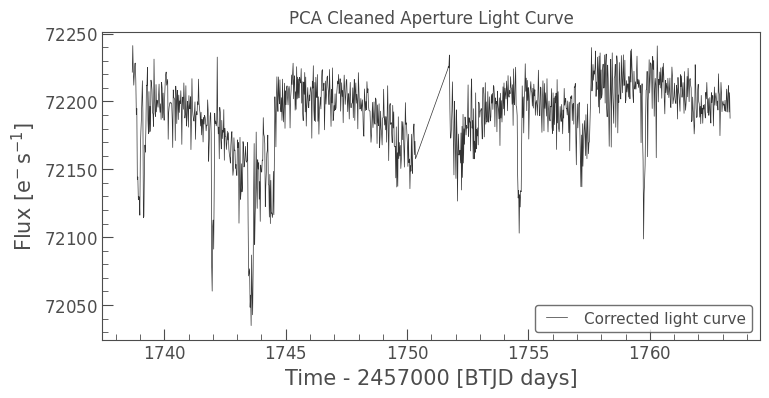

In [ ]:
# corrección con PCA

dm = lk.correctors.DesignMatrix(tpf.flux[:, ~aper]*aper.sum())
ndim = 2
dm = dm.pca(ndim)
dm_ = dm.append_constant()
dm_.name = "PCA Matrix"

corrector = lk.correctors.RegressionCorrector(tpf.to_lightcurve(aperture_mask=aper))
reg_corrected_lc = corrector.correct(dm_)

reg_corrected_lc.plot(label='Corrected light curve')
plt.title('PCA Cleaned Aperture Light Curve');


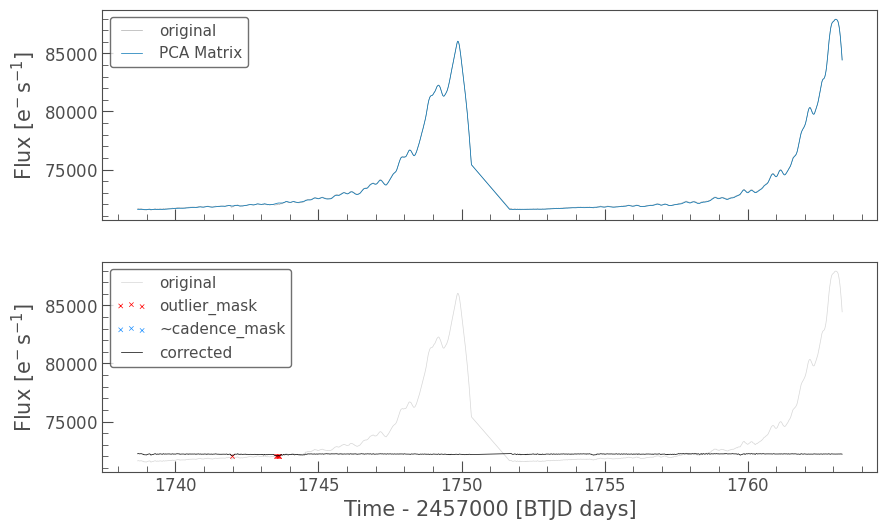

In [ ]:
# diagnóstico

corrector.diagnose();

El primer gráfico muestra la diferencia entre la curva original sin corregir y la matriz correctora generada por PCA, el segundo muestra la curva corregiida y las máscaras outlier, que son útiles pues nos muestran donde ocurren los tránsitos, y podemos ver que estos están apropiadamente distribuidos (no nos copan toda la curva, por ejemplo) por lo que son representativos y verifica la correctitud de este método de corrección.

Text(0.5, 1.0, 'Dimensions of PCA Matrix')

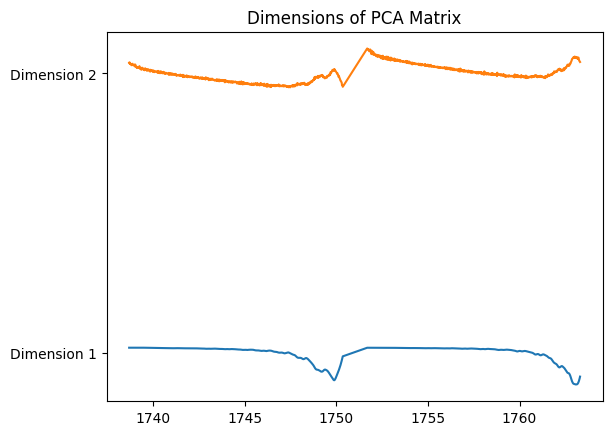

In [ ]:
# graficar dimensiones

fig, ax = plt.subplots()

ax.plot(tpf.time.value, dm.values + np.arange(ndim))
ax.set_yticks(np.arange(ndim))
ax.set_yticklabels(['Dimension 1', 'Dimension 2'])
ax.set_title('Dimensions of PCA Matrix')

Donde podemos ver que la segunda dimensión sube más abruptamente hacie la mitad y hacia el final en los mismos valores en que el comportamiento de la luz dispersada hacía aumentar vertiginisomente el flujo registrado. Además, la segunda dimensión suele ser más pareja en su comportamiento salvo los mínimos locales que alcanza que podrían corresponderse a los momentos de tránsito; podemos deducir así que la primera dimensión se corresponde al flujo limpio de nuestro planeta y la segunda al flujo ruido producido por el efecto de dispersión de la luz entre otros.

# P2

Para el desarrollo de esta parte descargamos la data de la cadencia de 2 minutos sin tendencia de nuestro planeta. Una vez más no especificamos sector y dejamos la descarga por defecto.

In [ ]:
# descarga de los datos

tpf_2min = lk.search_targetpixelfile(target, mission='TESS').download()

c:\Users\rirc1\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 45 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [ ]:
# usamos la apertura de tubería y la curva de luz sin corregir
# la apertura ya ha sido computada y la curva de luz ya ha sido des-tendenciada ('detrended', difícil traducir este término al español)

aper = tpf_2min.pipeline_mask
twomin_lc = tpf_2min.to_lightcurve()

Nuevamente as bajadas bruscas en el flujo corresponden a los tránsitos. Se visualiza además con zoom para que estos tránsitos puedan ser mejor apreciados en al menos el tramo mostrado.

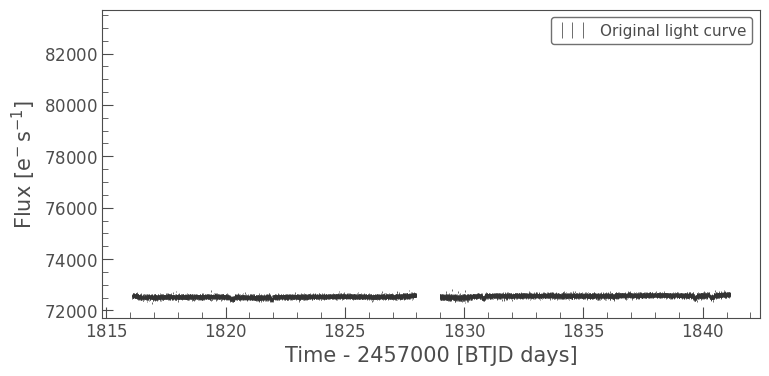

In [ ]:
ax = twomin_lc.errorbar(label='Original light curve')

(72000.0, 73000.0)

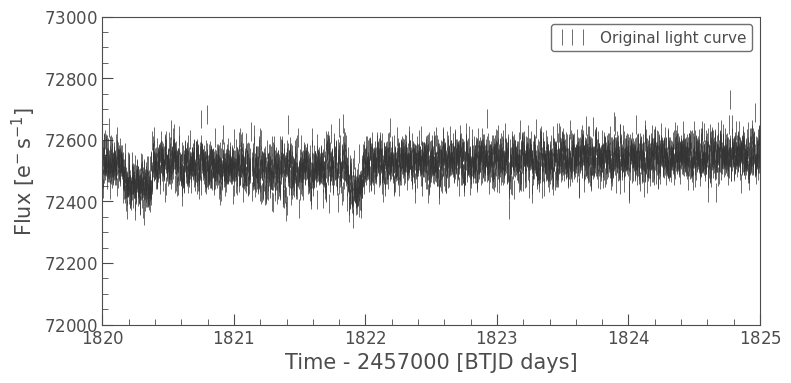

In [ ]:
ax = twomin_lc.errorbar(label='Original light curve')
ax.set_xlim(1820, 1825)
ax.set_ylim(72000, 73000)

Para ajustar un modelo al tránsito, se utiliza la función entregada por el profesor ya que se considera una buena aproximación del flujo pero ligeramente modificada para poder trabajar mejor. Se elimina la variable de periodo pues no se utilizaba, se modifica el return para que devuelva los mismos valores y no genere conflictos con la parte siguiente y en 'lambda_val' se evita la indefinición del caso en que se tome la raíz de un número negativo. Además, usando la base de datos mencionada por el auxilir 'ipac' vemos que tenemos datos como los radios del planeta, la estrella y la proporción entre estos. Cabe mencionar que en un principio se intentó trabajar sin entregar el radio del planeta sino la proporción entre este y el radio de la estrella pero generó errores importantes más adelante; no se pudo calcular la matriz de covarianza para la segunda parte y por tanto se llegó a desviaciones estándar infinitas, por lo que esta modificación finalmente se descartó.

In [ ]:
def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - prop: the proportion between the star and the planet radius
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((np.maximum(Rs**2-r**2,0) )/Rs**2)
    
    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration

    return np.where((t < t_ingress) | (t > t_egress), F, F - delta_F)

Primero trabajamos con una curva propuesta (o adivinada, del inglés 'guessed curve'). Los datos de radios de estrella y planeta fueron obtenidos de la base de datos mencionada por el auxiliar, estos estaban en radios solares y tierra respectivamente, como es usual en astronomía. Para inputarlos a la función se "normalizaron"; se convirtieron ambos a una unidad común (kilómetros), dando así $R_p = 21725.11km$ y $R_s = 653958km$ y como los parámetros que recibe la función son adimensionales se dividieron ambos por $R_s$ llegando así a $R_p^* = 0.0332$ y $R_s^* = 1$ que finalmente son los valores entregados a la función. El resto de datos fueron escogidos mediante ensayo y error buscando valores adecuados a simple vista.

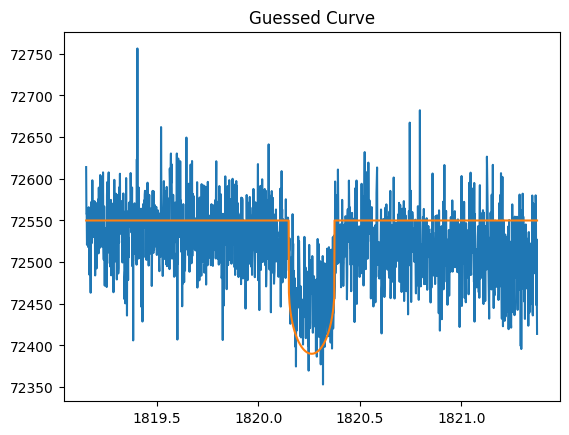

In [ ]:
F, Rp, Rs, c, t_ingress, t_duration = 72550, 0.0332, 1, 1, 1820.15, 0.2252
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration) for t in twomin_lc['time'].btjd]

# curva propuesta

fig = plt.figure()
plt.title("Guessed Curve")
filt = (twomin_lc['time'].btjd>t_ingress-1.) * (twomin_lc['time'].btjd<t_ingress+t_duration+1.)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt]);


Parámetros ajustados obtenidos
 
F = 72525.28050874549
Rp = -12.828550195971857
Rs = -386.55507814154885
c = -0.15244751468858264
t_igress = 1820.1476375657896
t_duration = 0.2114393692950212


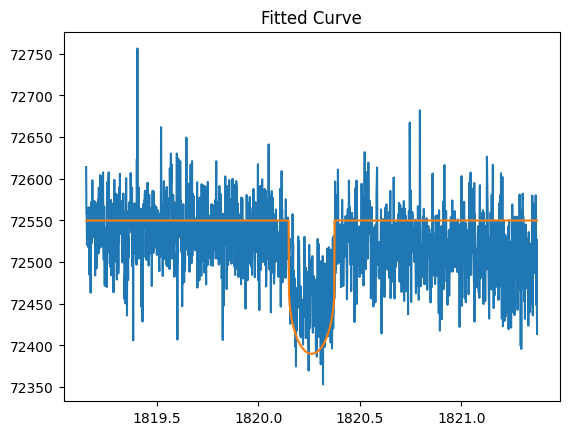

In [ ]:
params, cov = curve_fit(flux_at_time, twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt], p0 = [72550, 0.0332, 1, 1, 1820.15, 0.2252])

# curva ajustada y parámetros obtenidos

mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration) for t in twomin_lc['time'].btjd]
fig = plt.figure()
plt.title("Fitted Curve")
filt = (twomin_lc['time'].btjd>t_ingress-1.) * (twomin_lc['time'].btjd<t_ingress+t_duration+1.)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt]);

print("Parámetros ajustados obtenidos")
print(" ")
print("F = " + str(params[0]))
print("Rp = " + str(params[1]))
print("Rs = " + str(params[2]))
print("c = " + str(params[3]))
print("t_igress = " + str(params[4]))
print("t_duration = " + str(params[5]))

A simple vista podemos observar que la curva ajustada se corresponde con la distribución del flujo y además es prácticamente igual que la curva propuesta, lo que es un buen indicio de la correctitud de nuestro modelo. Además en general los parámetros obtenidos del ajuste son bastante similares a los propuestos como $p_0$, salvo aquellos cuya magnitud era menor a $1$ y en el ajuste resultaron como valores negativos, sin embargo era relativamente esperable pues el modelo no tiene cómo saber que un valor negativo es inadecuado, aún así no son tan lejanos y están dentro de una diferencia aceptable.

## 2

Para calcular la de nuestros resultados utilizamos la diagonal de la matriz de covarianza, tomando la raíz cuadrada tendremos la desviación estándar.

In [ ]:
desv = np.sqrt(np.diag(cov))

print("Desviaciones estándar")
print(" ")
print("F = " + str(desv[0]))
print("Rp = " + str(desv[1]))
print("Rs = " + str(desv[2]))
print("c = " + str(desv[3]))
print("t_igress = " + str(desv[4]))
print("t_duration = " + str(desv[5]))


Desviaciones estándar
 
F = 1.0623115891855197
Rp = 62955.11658031307
Rs = 1896994.8360556394
c = 0.2944915400092059
t_igress = 0.05311405996269943
t_duration = 0.0810292459214666


Podemos ver que todas las desviaciones son bajas salvo aquellas relacionadas con los radios de los cuerpos celestes estudiados, lo que nos dice que estos resultados probablemente no son cercanos a los reales (como quedó patente en el punto anterior). Esto se puede deber al cálculo que realiza el algoritmo de la función de flujo utilizada, pues esta trabaja más con la proporción de los radios que con el radio del planeta en sí, generando así también una mayor incerteza en los radios antes que en la proproción de estos. En general el ajuste es adecuado salvo por los resultados de los radios. Así mismo podemos notar que la proporción entre estos radios obtenidos y sus desviaciones sí son bastante similares a la proporción original utilizada de $0.0332$, lo que verifica que el modelo funciona bien salvo para obtener estos valores en específico.

In [ ]:
print(desv[1] / desv[2])
print(params[1] / params[2])

0.033186762232423166
0.03318686241983424


Una solución para obtener bien los radios habría sido entregar como parámetro en vez del radio del planeta la proporción entre este y el radio de la estrella, pero como ya comenté anteriormente esto produjo otros errores en el modelo que dio lugar a varianzas infinitas y finalmente se tuvo que descartar.